Test notebook


In [3]:
# %%

import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np



In [4]:

''' Format plots'''

fsize = 11
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["yellowgreen", "black", "dimgrey", 'darkgreen', 'aqua', 'deepskyblue', 'orange', 'blue', 'indianred']) 



Import the data from the runs 

In [12]:
# all_strike_prices = np.load(f'C:/Users/LukaK/OneDrive - Durham University/Projects/Agent based modelling easy/PowerSim/data_out/all_strike_prices.npy')
# total_per_tech = np.load(f'C:/Users/LukaK/OneDrive - Durham University/Projects/Agent based modelling easy/PowerSim/data_out/total_per_tech.npy')

import os

directory = 'data/total_per_tech'

npy_files = [filename for filename in os.listdir(directory) if filename.endswith('.npy')]

# Load the first file to initialize the array


arrays =[]
# stack the remaining files
for filename in npy_files[1:]:
    filepath = os.path.join(directory, filename)
    file_data = np.load(filepath)
    arrays.append(file_data)

full_data = np.stack(arrays, axis =0)
'''[run, year, tech, hour]'''

print(np.shape(full_data))
print(np.shape(all_strike_prices))
print(np.shape(total_per_tech))



''' set the number parameters from the run'''
n_days = 36
n_years = 30


descriptor  = '50 pound carbon tax actually 36 days'
tech_types = ['nuclear', 'coal', 'fossil_fuel', 'bioenergy', 'wind_onshore', 'wind_offshore', 'solar', 'hydro', 'CCGT']


(3, 30, 9, 96)


NameError: name 'all_strike_prices' is not defined

Make the graphs

(30, 9, 864)
(9, 864)


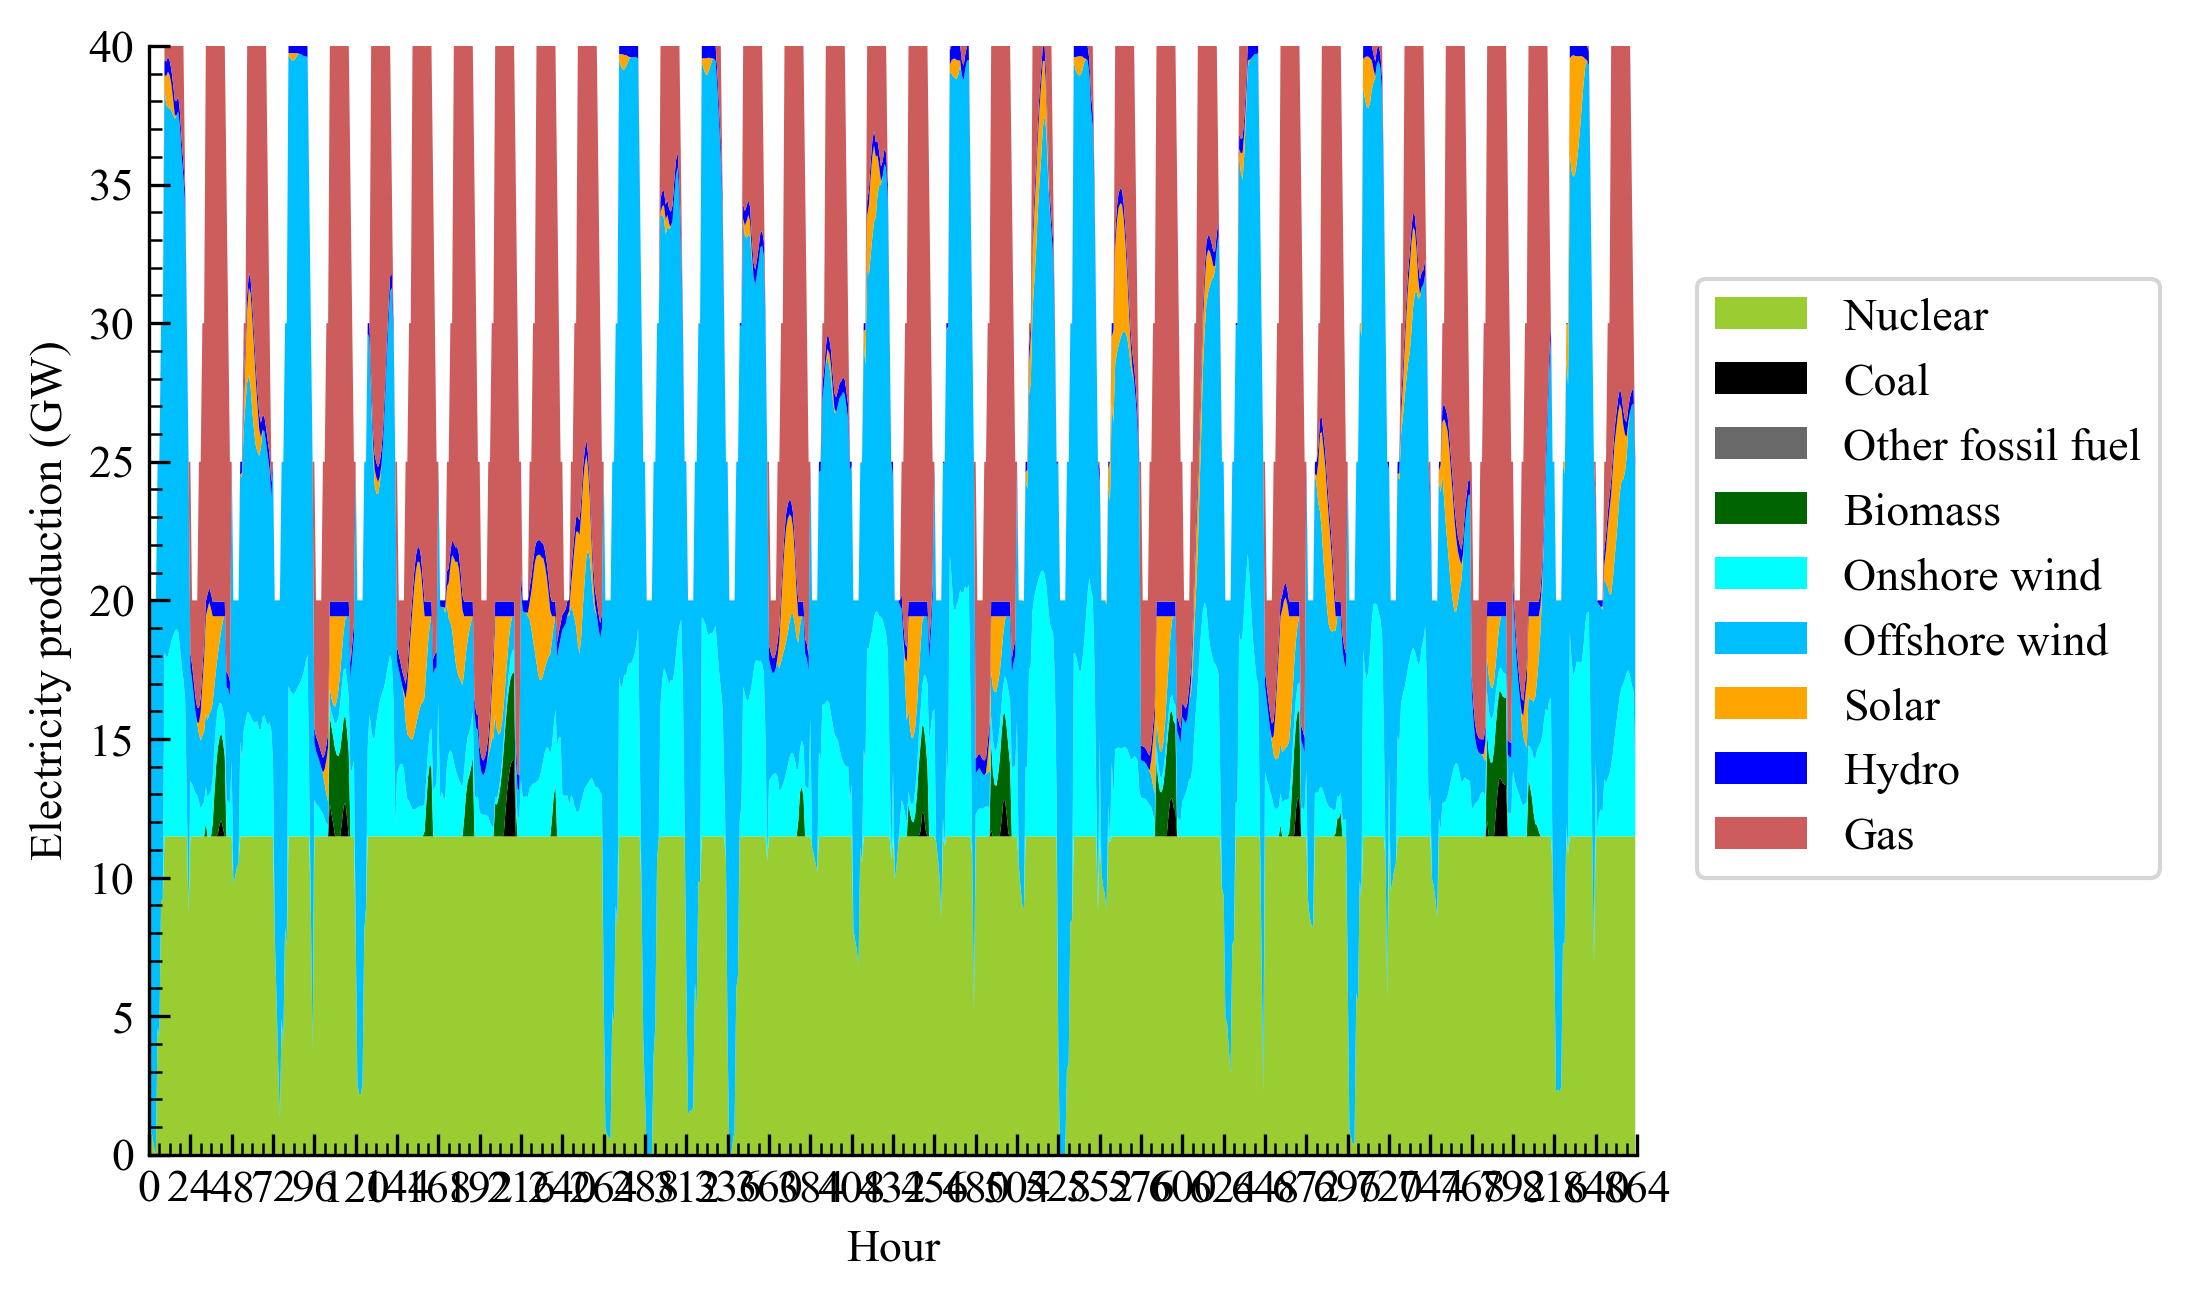

In [22]:


#%%
'''Stacked plot of daily production'''

fig, ax = plt.subplots()


print(np.shape(total_per_tech))



ydata = total_per_tech[29,:,:]/1000

print(np.shape(ydata))

xdata = range((n_days*24))

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["yellowgreen", "black", "dimgrey", 'darkgreen', 'aqua', 'deepskyblue', 'orange', 'blue', 'indianred']) 

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']
ax.stackplot(xdata,*ydata, labels = [t for t in tech_types_named])
#have to remove the historical data from the plot



ax.set_ylabel('Electricity production (GW)')
ax.set_xlabel('Hour')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xlim(0, len(xdata))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(fname = f'{descriptor}year production by day', bbox_inches = "tight" )
plt.show()



(30, 9)


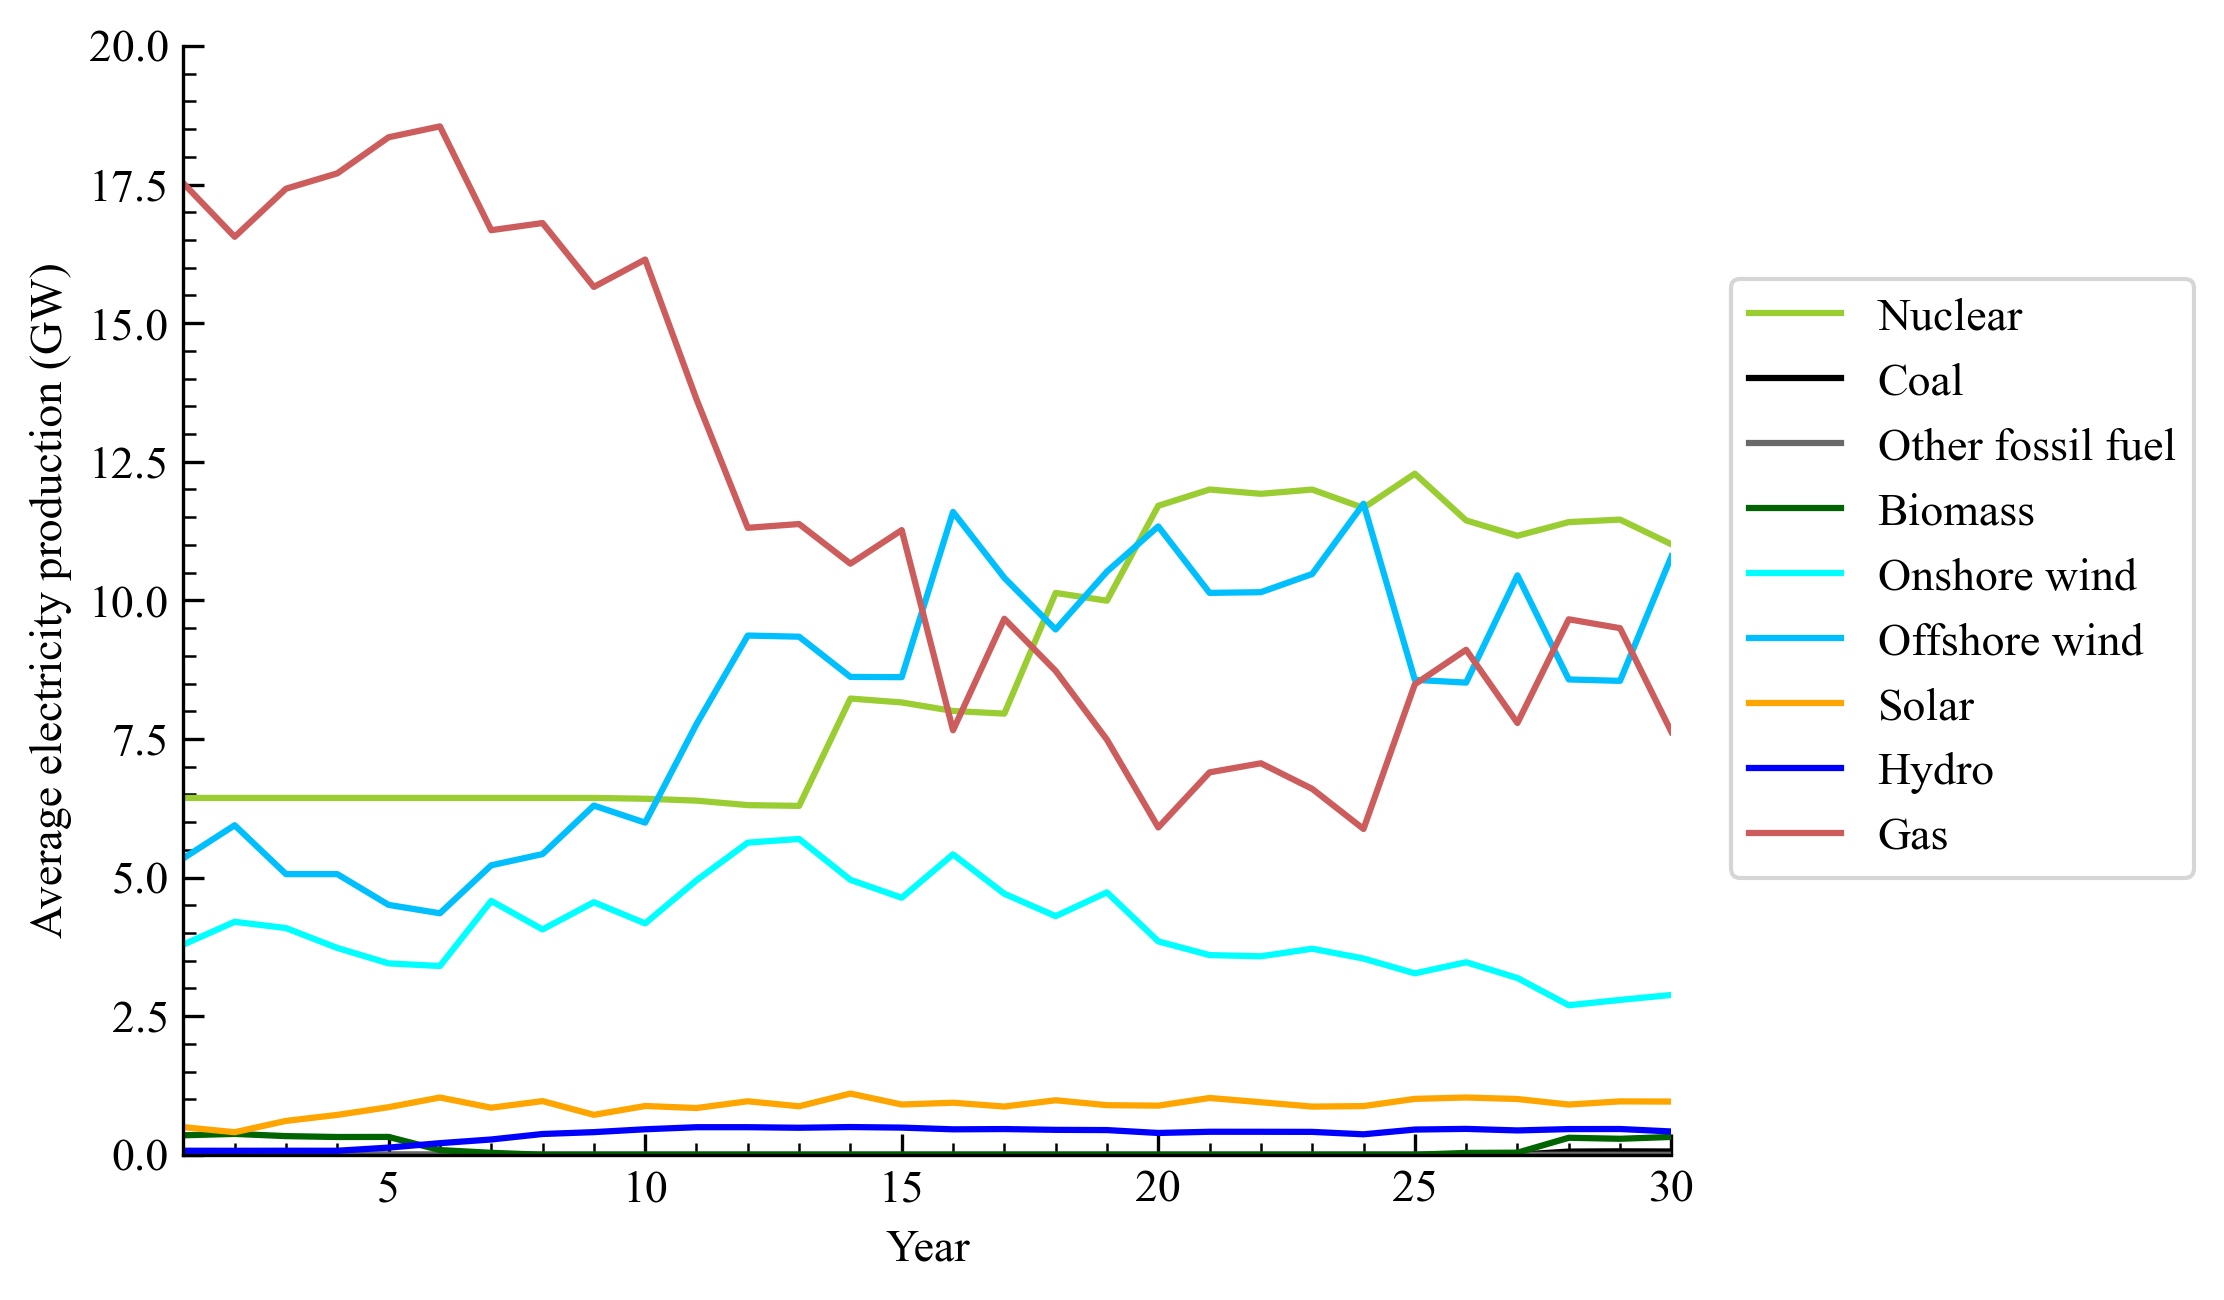

In [23]:

    

fig, ax = plt.subplots()


ydata = np.average(total_per_tech, axis = 2)
print(np.shape(ydata))
xdata = range(1, n_years+1)

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']
for i in range(9):
    y = ydata[:,i]/(960)
    ax.plot(xdata,y, label =  tech_types_named[i])
#have to remove the historical data from the plot

ax.set_ylabel('Average electricity production (GW)')
ax.set_xlabel('Year')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlim(1, max(xdata))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(fname = f'{descriptor}average_production yearly', bbox_inches = "tight" )
plt.show()




In [24]:

'''Get average yearly prices'''

np.shape(all_strike_prices)

average_daily_p = np.mean(all_strike_prices, axis = 1)
np.shape(average_daily_p)

av_daily_2d = average_daily_p.reshape(n_years,n_days)

mean_yearly = np.mean(av_daily_2d, axis = 1)

No handles with labels found to put in legend.


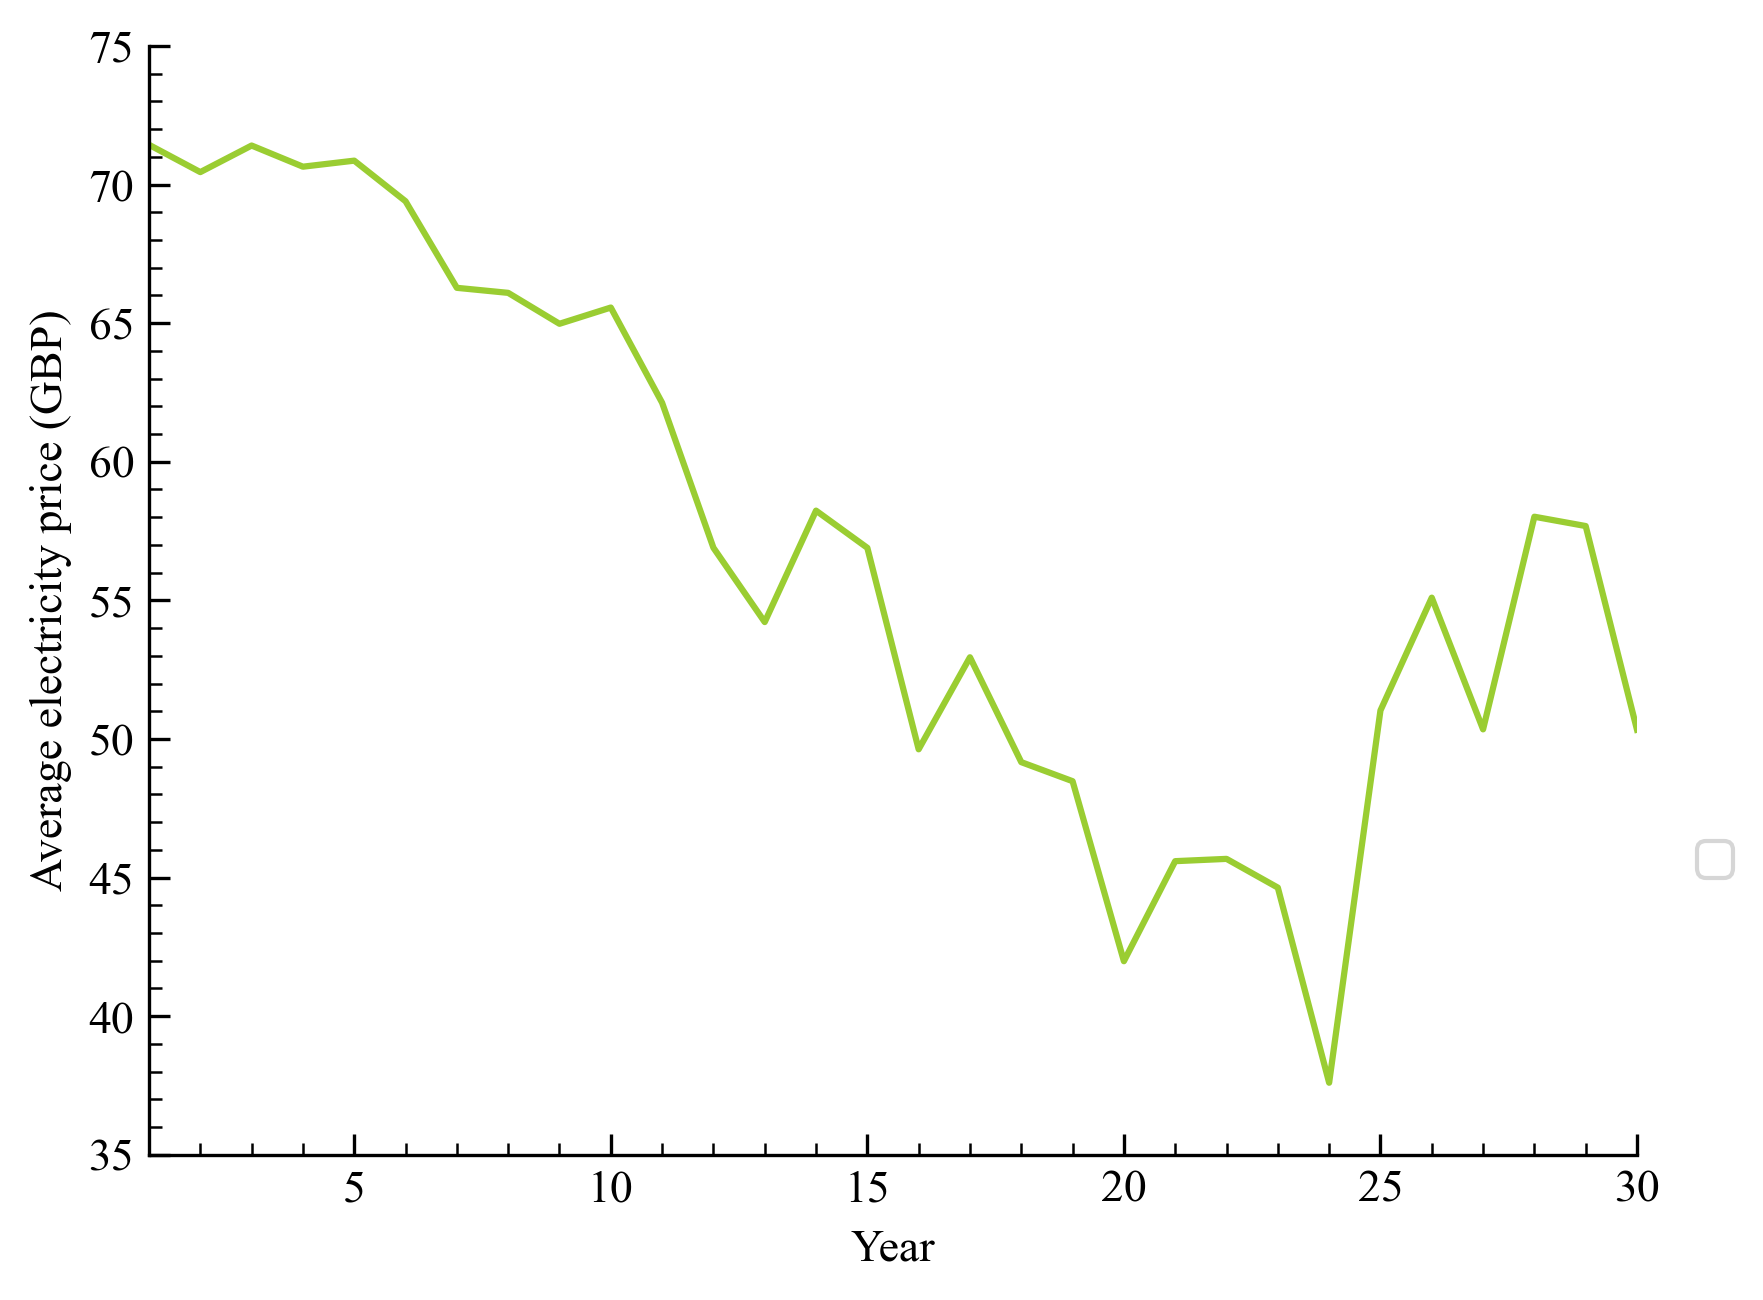

In [25]:

fig, ax = plt.subplots()



ydata = mean_yearly

xdata = range(1, n_years+1)

# print(ydata)
tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']

ax.plot(xdata,ydata)
#have to remove the historical data from the plot

ax.set_ylabel('Average electricity price (GBP)')
ax.set_xlabel('Year')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlim(1, max(xdata))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc = (1.04, 0.25))
# ax.set_xlim(0, n_years)
# ax.set_ylim(min(average_yearly_strike_prices) - 5, (max(average_yearly_strike_prices) + 5))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(fname = f'{descriptor}av. price.png', bbox_inches = "tight" )
plt.show()


In [41]:
import electricity_company
import pickle

with open('powerplants.pickle', 'rb') as f:
    obj_list_new = pickle.load(f)


In [57]:


tech_types_named =  ['Nuclear', 'Coal', 'Other fossil fuel','Biomass', 'Onshore wind', 'Offshore wind', 'Solar', 'Hydro', 'Gas']

for obj in obj_list_new: 
    if obj.name == 'RWE Npower':
        elec_co = obj

plant_list_npower = elec_co.power_plants

for plant in plant_list:
    print(plant.capacity_MW)

        for tech in tech_types:
        energy = [(plant.energy_supplied_per_hour[-(24*world.n_days):]) for plant in plant_list if plant.technology == tech and len(plant.energy_supplied_per_hour) >= 24]
        energy = np.sum(energy, axis = 0)
        y_total_per_tech.append(energy)

0.505
0.505
0.56
0.6
0.75
0.78
0.85
0.95
1.35
2.0
2.0
2.274
2.3
2.3
2.3
2.4
2.5
2.6
2.75
2.75
2.969
3.0
3.0
3.5
3.9
4.0
4.1
4.1
5.0
5.15
5.15
5.5
6.0
6.0
6.0
6.6
9.0
9.1
9.2
9.4
9.4
9.6
9.9
14.0
14.98
15.6
15.6
15.8
16.0
17.0
17.0
19.3
20.0
20.0
20.5
24.7
26.65
32.8
33.0
34.85
36.8
40.0
44.0
44.0
50.0
54.0
55.0
57.4
59.8
60.0
60.0
65.0
84.0
90.0
90.0
96.0
100.0
140.0
219.0
352.8
395.0
400.2
420.0
576.0
630.0
723.0
857.0
1450.0
1772.0
2199.0
5.39904
1.21275
7.63
5.41057
4.857
18.73872
0.054
9.6
9.9
1.51164
2.9
119.8
0.958
0.8064
94.05
20.5
4.6
7.2
